In [15]:
import time
import datetime

import cv2

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

from unet2 import ensure_directory_exists, unet_model, load_dataset, dice_loss

# Chargement de donnees

In [8]:
data_dir = r'data_folder/data_folder'
X, Y = load_dataset(data_dir, img_size=(256, 256), image_debut=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

S1 paths found: ['data_folder/data_folder\\s1\\11_s1_tile_0_9216.tif', 'data_folder/data_folder\\s1\\11_s1_tile_10240_9472.tif', 'data_folder/data_folder\\s1\\11_s1_tile_1024_5888.tif']
S2 paths found: ['data_folder/data_folder\\s2\\11_s2_tile_0_9216.tif', 'data_folder/data_folder\\s2\\11_s2_tile_10240_9472.tif', 'data_folder/data_folder\\s2\\11_s2_tile_1024_5888.tif']
Mask paths found: ['data_folder/data_folder\\masks\\11_mask_tile_0_9216.tif', 'data_folder/data_folder\\masks\\11_mask_tile_10240_9472.tif', 'data_folder/data_folder\\masks\\11_mask_tile_1024_5888.tif']
Paired paths: [('data_folder/data_folder\\s1\\11_s1_tile_0_9216.tif', 'data_folder/data_folder\\s2\\11_s2_tile_0_9216.tif', 'data_folder/data_folder\\masks\\11_mask_tile_0_9216.tif'), ('data_folder/data_folder\\s1\\11_s1_tile_10240_9472.tif', 'data_folder/data_folder\\s2\\11_s2_tile_10240_9472.tif', 'data_folder/data_folder\\masks\\11_mask_tile_10240_9472.tif'), ('data_folder/data_folder\\s1\\11_s1_tile_1024_5888.tif', 'd

# Creation du modele

In [9]:
model = unet_model(input_shape=(256, 256, 8))  # Update the number of channels as per combined S1 and S2
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 16  1168        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 256, 256, 16  64         ['conv2d_23[0][0]']              
 ormalization)                  )                                                           

# Entrainement

In [10]:
image_debut = 0
image_fin = 1000
nEpoch = 5
X_train_part, Y_train_part = X_train[image_debut:image_fin], Y_train[image_debut:image_fin]
batch_size = 16
params = [image_fin-image_debut, nEpoch,batch_size]

### Creation des dossiers

In [5]:
import os
import numpy as np

In [17]:
save_folder = f"runs/model{datetime.datetime.now().strftime('%y-%m-%d %H-%M-%S')}"
ensure_directory_exists(save_folder)

graph_folder = f"results/graphs{params[0],params[1],params[2],datetime.datetime.now().strftime('%H-%M')}"
ensure_directory_exists(graph_folder)

pred_folder = os.path.join(save_folder, 'predicted_masks')
ensure_directory_exists(pred_folder)

mask_folder = os.path.join(save_folder, 'masks')
ensure_directory_exists(mask_folder)

checkpoint_file = os.path.join(save_folder, 'checkpoint.model.keras')

In [16]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_file,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
results = []

In [18]:
start_time = time.time()
#for k in range(6):
#Xk_train = X_train[k*batchTrain:(k+1)*batchTrain]
#Yk_train = Y_train[k*batchTrain:(k+1)*batchTrain]
#history = model.fit(Xk_train, Yk_train, batch_size=16, epochs=15, validation_split=0.3)
history = model.fit(X_train_part, Y_train_part, batch_size=batch_size, epochs=nEpoch, validation_split=0.3, callbacks=[model_checkpoint_callback])
end_time = time.time()
elapsed_time = end_time - start_time
print(f'{elapsed_time:.01f}s')

Epoch 1/5
83/83 [==============================] - 698s 8s/step - loss: 0.5502 - accuracy: 0.7500 - val_loss: 1.0051 - val_accuracy: 0.6544
Epoch 2/5
83/83 [==============================] - 665s 8s/step - loss: 0.2206 - accuracy: 0.9250 - val_loss: 1.5153 - val_accuracy: 0.6544
Epoch 3/5
83/83 [==============================] - 669s 8s/step - loss: 0.1455 - accuracy: 0.9503 - val_loss: 1.2527 - val_accuracy: 0.6544
Epoch 4/5
83/83 [==============================] - 676s 8s/step - loss: 0.1155 - accuracy: 0.9596 - val_loss: 1.5339 - val_accuracy: 0.6544
Epoch 5/5
83/83 [==============================] - 666s 8s/step - loss: 0.0948 - accuracy: 0.9662 - val_loss: 1.1959 - val_accuracy: 0.6544
3374.0s


# Prediction

In [19]:
loss_train = []
loss_test = []

In [20]:
#Yk_pred = model.predict(X_test)
Y_pred = model.predict(X_test)
Y_pred_train = model.predict(X_train)

loss_train.append((binary_crossentropy(Y_train,Y_pred_train),
                  dice_loss(Y_train,Y_pred_train)))
loss_test.append((binary_crossentropy(Y_train,Y_pred_train),
                 dice_loss(Y_train,Y_pred_train)))

print('loss : bce , dice')
print(f'loss_train : {loss_train}')
print(f'loss_test : {loss_test}')
#thresholded_pred = (Yk_pred > np.median(Yk_pred)).astype(np.uint8)

59/59 [==============================] - 167s 3s/step
loss : bce , dice
loss_train : [(<tf.Tensor: shape=(1886, 256, 256), dtype=float32, numpy=
array([[[0.10215762, 0.0617252 , 0.05740139, ..., 0.0523613 ,
         0.05456971, 0.07242899],
        [0.06417752, 0.03307143, 0.03038569, ..., 0.02709209,
         0.02764403, 0.04953263],
        [0.05808401, 0.0296926 , 0.02642998, ..., 0.02389818,
         0.02530984, 0.04661252],
        ...,
        [2.65466   , 3.1902013 , 3.2068815 , ..., 0.02393713,
         0.0252042 , 0.04820297],
        [2.7123663 , 3.2231908 , 3.2283888 , ..., 0.0275501 ,
         0.03017613, 0.05591612],
        [2.3650541 , 2.607924  , 2.619471  , ..., 0.06238858,
         0.06686469, 0.10247217]],

       [[0.10435506, 0.06432479, 0.06070841, ..., 0.05125541,
         0.05318965, 0.07184409],
        [0.06746065, 0.03601523, 0.03402811, ..., 0.02563615,
         0.02644902, 0.04807445],
        [0.06224769, 0.03352189, 0.03064028, ..., 0.02292363,
         0

# Seuillage binaire

In [21]:
thresholded_pred = []
thresholded_pred_train = []

In [22]:
for img in Y_pred:
    thresholded_pred.append(cv2.threshold((255*img).round().astype('uint8'),0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1])
    #thresholded_pred.append((255*img).round().astype('uint8'))
for img in Y_pred_train:
    thresholded_pred_train.append(cv2.threshold((255*img).round().astype('uint8'),0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1])
    #thresholded_pred_train.append((255*img).round().astype('uint8'))

for i in range(X_test.shape[0]):
    cv2.imwrite(os.path.join(mask_folder, f'mask_{i+1}.tif'), Y_test[i])
    #cv2.imwrite(os.path.join(pred_folder, f'pred_{i+1}.tif'), Yk_pred[i])
    cv2.imwrite(os.path.join(pred_folder, f'pred_{i+1}.tif'), Y_pred[i])

# Affichages

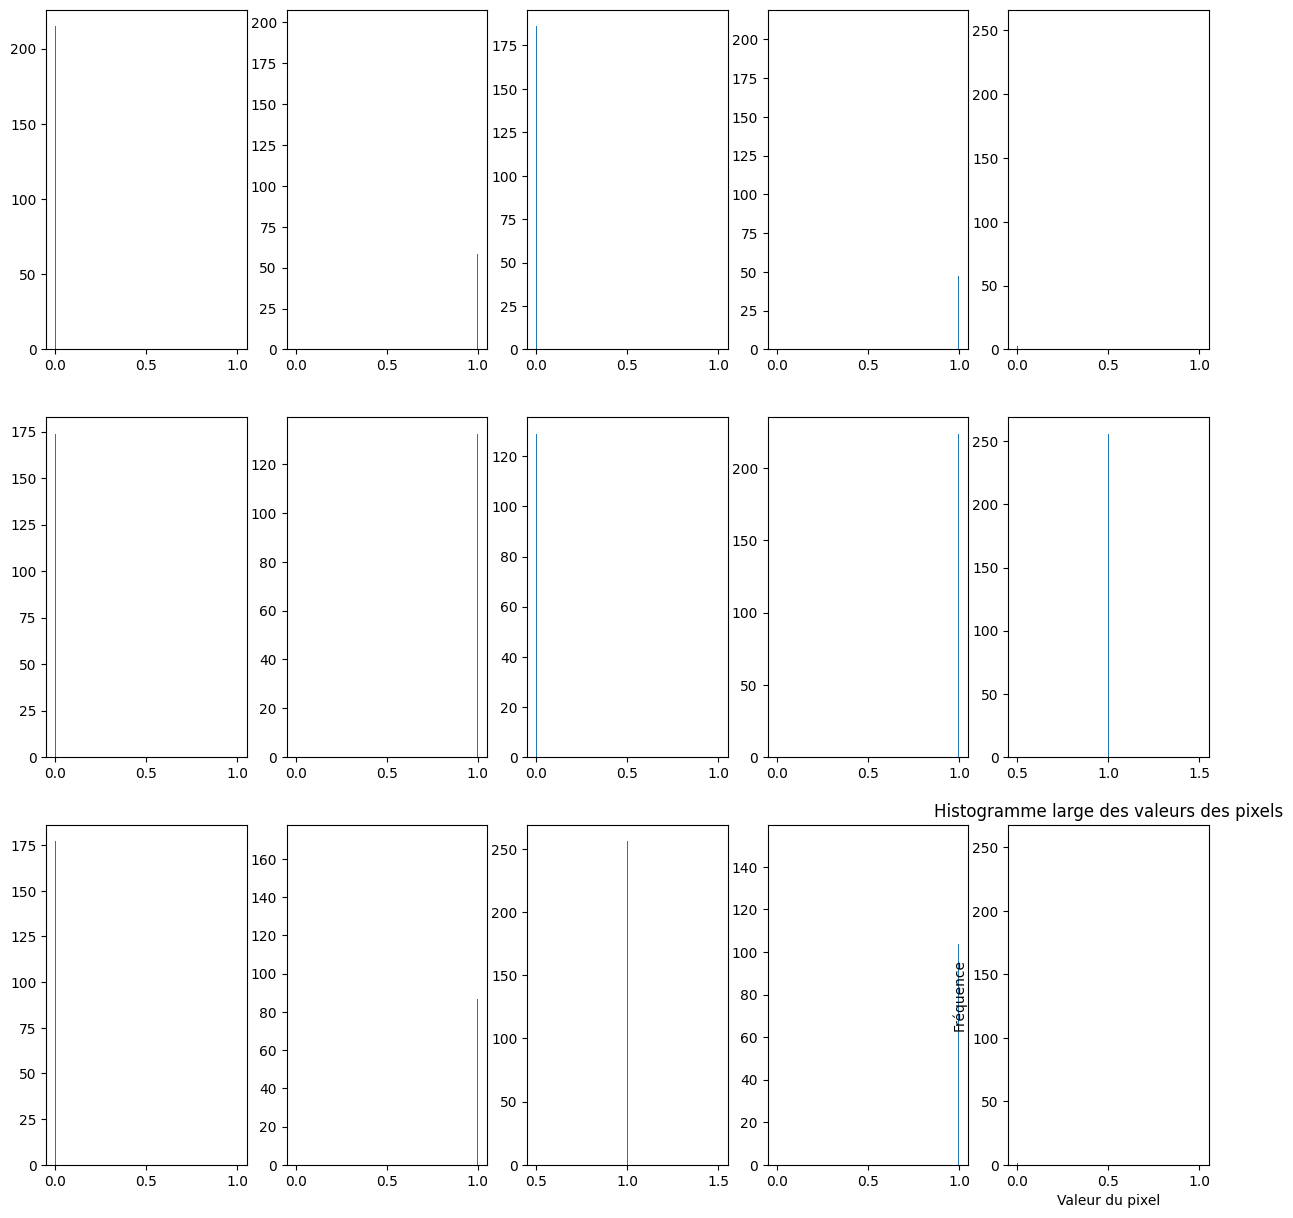

In [23]:
#plt.hist(Y_pred[1].ravel(), bins=256, density=True)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15))
# Afficher chaque image dans une des sous-graphes
for i, ax in enumerate(axes.flat):
    ax.hist(Y_train[i].ravel(), bins=256, density=True)
plt.title('Histogramme large des valeurs des pixels')
plt.xlabel('Valeur du pixel')
plt.ylabel('Fréquence')
plt.savefig(os.path.join(graph_folder,'histoLarge.png'))
plt.show()

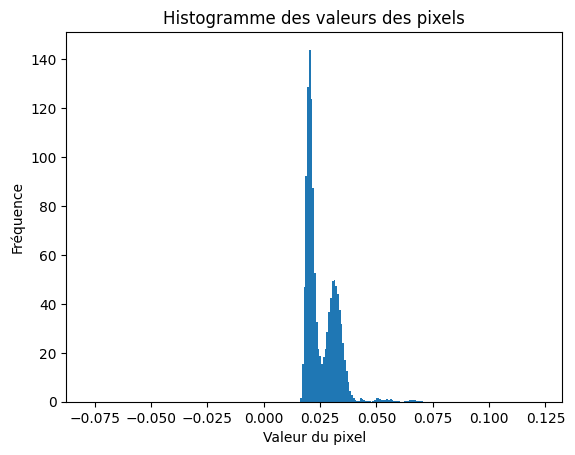

In [24]:
#plt.hist(Yk_pred[1].ravel(), bins=256, range=(np.median(Yk_pred[1])-0.1,np.median(Yk_pred[1])+0.1), density=True)
plt.hist(Y_pred[1].ravel(), bins=256, range=(np.median(Y_pred[1])-0.1,np.median(Y_pred[1])+0.1), density=True)
plt.title('Histogramme des valeurs des pixels')
plt.xlabel('Valeur du pixel')
plt.ylabel('Fréquence')
plt.savefig(os.path.join(graph_folder,'histogramme.png'))
plt.show()

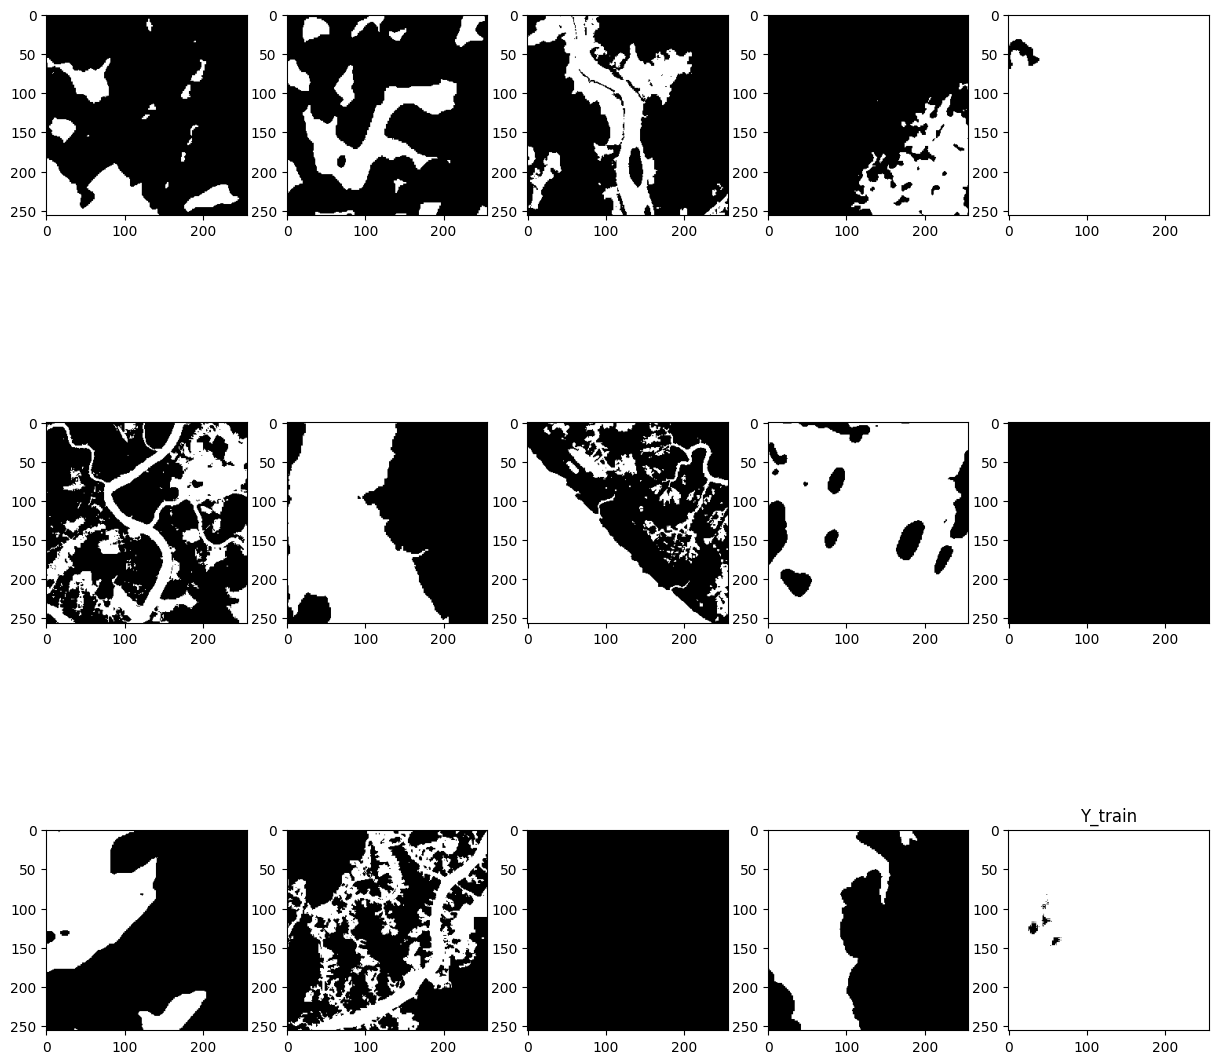

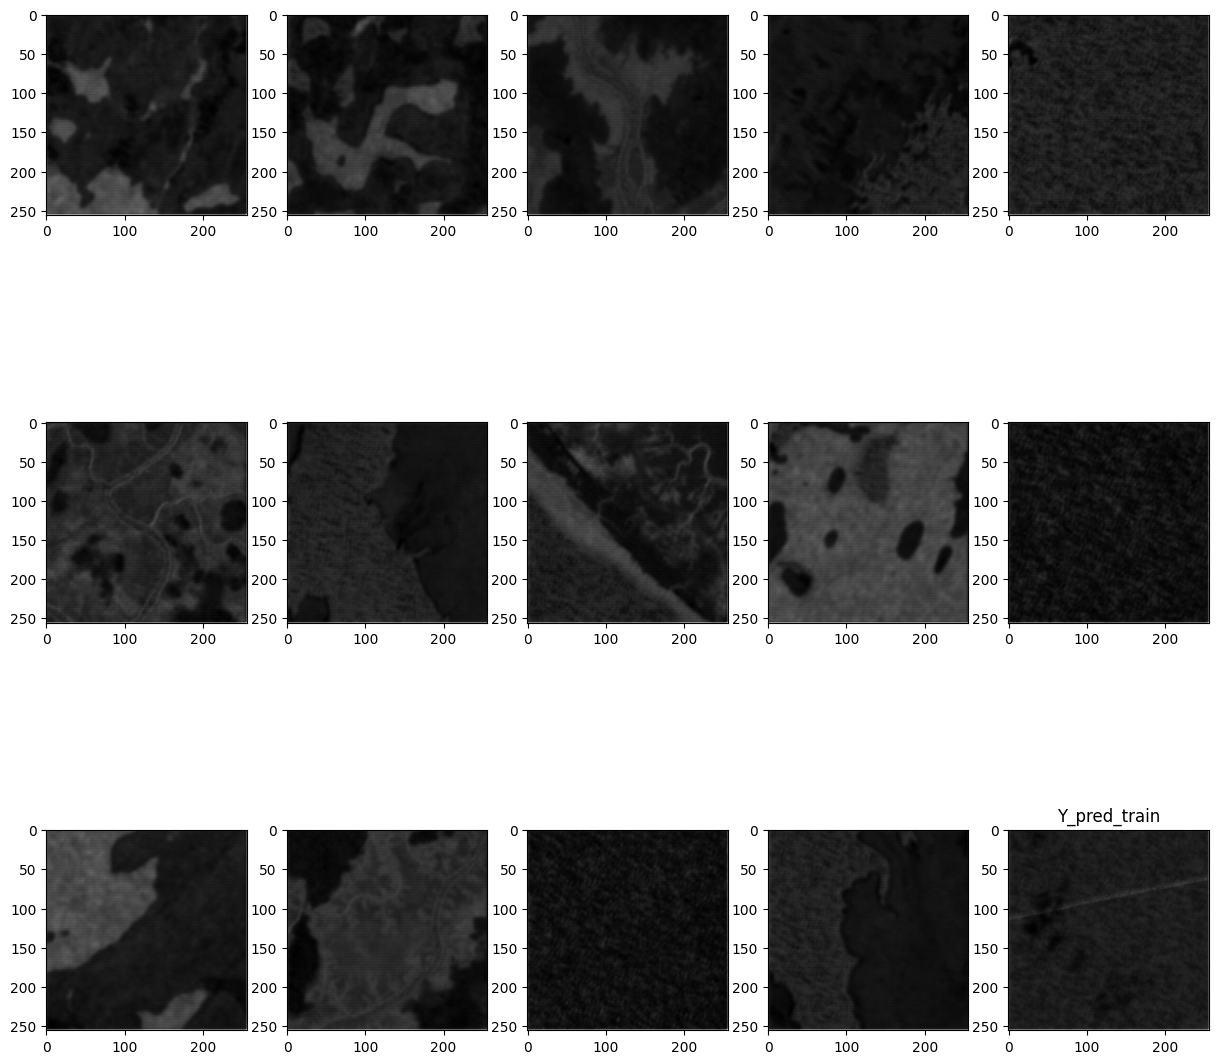

In [25]:
for e in ['Y_train', 'Y_pred_train']:
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15))
    # Afficher chaque image dans une des sous-graphes
    for i, ax in enumerate(axes.flat):
        ax.imshow(eval(e)[i], cmap='gray')  # Afficher l'image en niveaux de gris
    plt.title(e)
    plt.savefig(os.path.join(graph_folder,f'{e}.png'))
    plt.show()

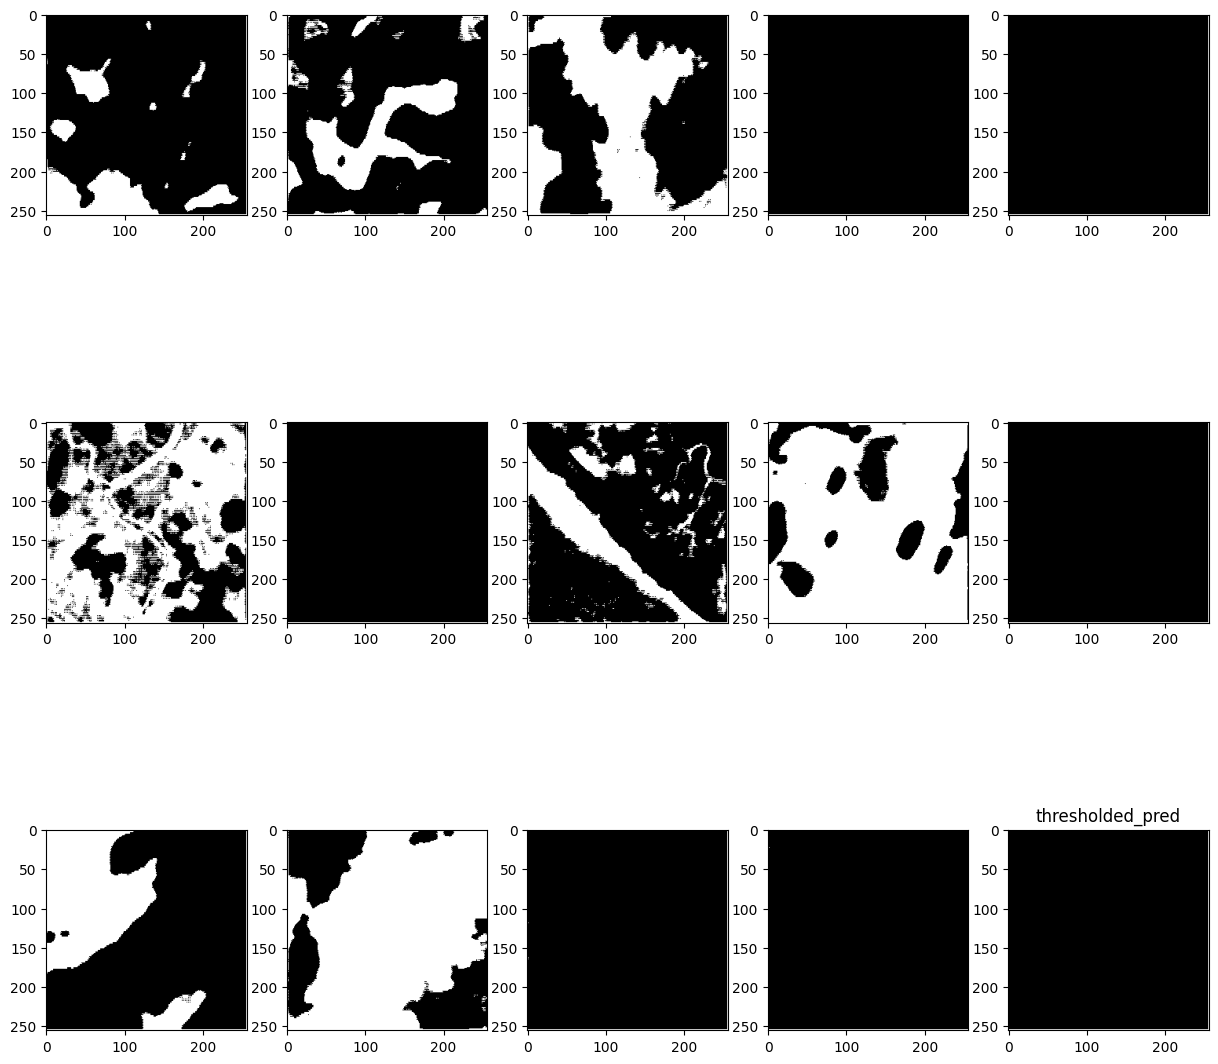

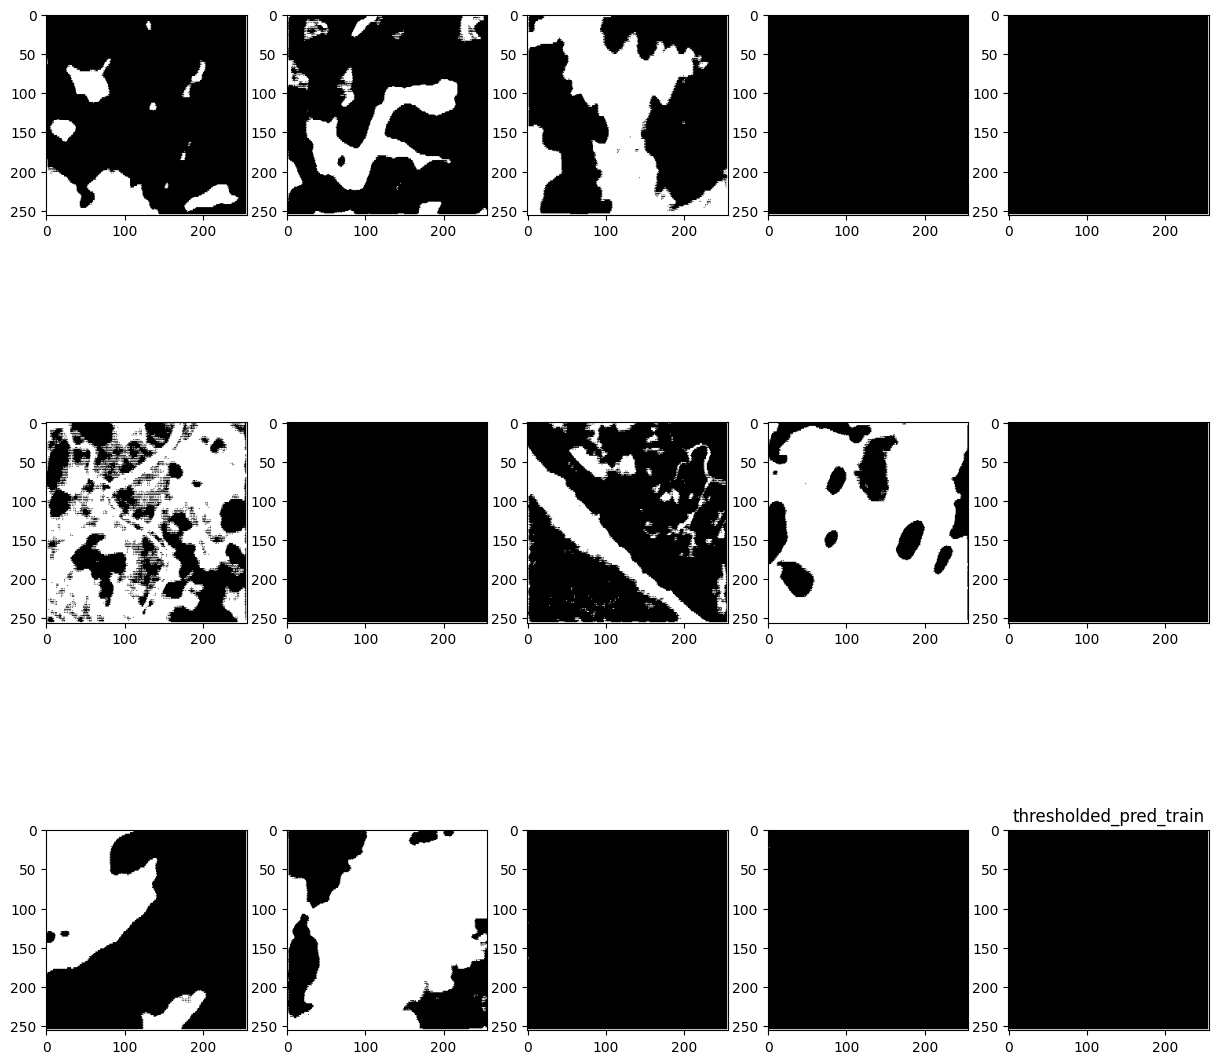

In [27]:
for e in ['thresholded_pred', 'thresholded_pred_train']:
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,15))
    # Afficher chaque image dans une des sous-graphes
    for i, ax in enumerate(axes.flat):
        ax.imshow(thresholded_pred_train[i], cmap='gray')  # Afficher l'image en niveaux de gris
    plt.title(e)
    plt.savefig(os.path.join(graph_folder,f'{e}.png'))
    plt.show()

In [28]:
model.save(os.path.join(save_folder,'model.keras'))
results.append(history.history)

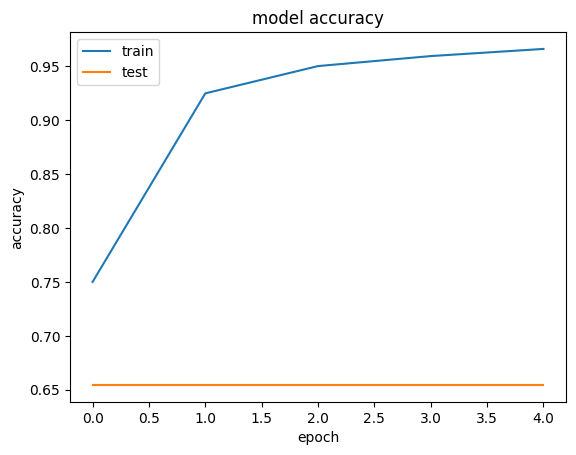

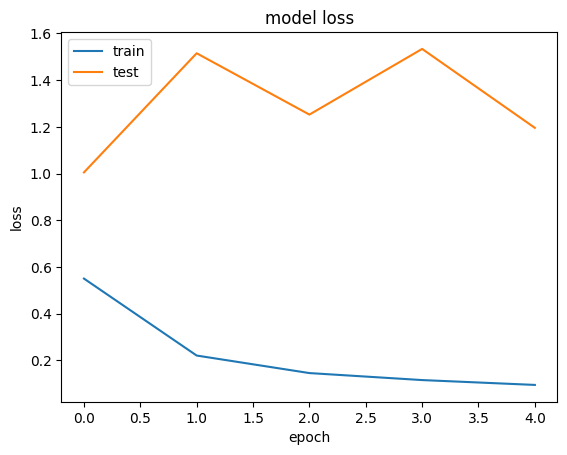

In [29]:
for e in ['accuracy', 'loss']:
    plt.plot(history.history[e])
    plt.plot(history.history[f'val_{e}'])
    plt.title(f'model {e}')
    plt.ylabel(e)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(os.path.join(graph_folder,f'{e}.png'))
    plt.show()